In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
    print("Stamnes' DISORT imported.")
except ImportError:
    disort_is_installed = False
    print("Stamnes' DISORT unavailable. Cached results will be used.")

Stamnes' DISORT imported.


# Table of Contents
* [9a and setup](#9a-and-setup)
* [9b](#9b)
* [9c](#9c)
* [9corrections](#9corrections)


# Test Problem 9:  General Emitting / Absorbing / Scattering Medium with Every Computational Layer Different

Similar to test problem 8 but with more atmospheric layers and more complicated phase functions.

Flux results in subproblems 9a, b can be compared to Tables VI-VII (beta = 0) of Devaux, C., Grandjean, P., Ishiguro, Y. and C.E. Siewert, 1979: On Multi-Region Problems in Radiative Transfer, *Astrophys. Space Sci.* 62, 225-233. The intensity field of the upwelling radiation, which can be compared to satellite measurements, is plotted for each subproblem.

# 9a and setup

**PythonicDISORT**

In [3]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.empty(6)
for i in range(6):  # Six layers of different thicknesses
    tau_arr[i] = np.sum(np.arange(i + 2))
omega_arr = 0.6 + np.arange(1, 7) * 0.05  # Six different single-scattering albedos for the six layers
NQuad = 8  # 8 streams (4 quadrature nodes for each hemisphere)
Leg_coeffs_all = np.zeros((6, 9))
Leg_coeffs_all[:, 0] = 1  # The phase functions for all six layers are isotropic
mu0 = 0
I0 = 0  # No direct beam
phi0 = 0

# Optional (used)
b_neg = 1 / pi  # Intensity of top-boundary isotropic illumination

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes=[]
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [4]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
)

**Setup for tests**

In [5]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [6]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 1.05, 2.1, 6, 21])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [7]:
# Stamnes' DISORT arguments
nlyr = 6
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = b_neg
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [8]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/9a_test.npz")

**Comparisons**

In [9]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 3.745465768090206e-08
Difference ratio = 6.484678735489018e-07

Downward (diffuse) fluxes
Difference = 2.384185792125848e-07
Difference ratio = 1.0299048886922722e-06

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 1.05
Max pointwise difference = 1.3721596303639672e-08
At tau = 21.0
Max pointwise difference ratio = 9.792896740162377e-07



**Does the test pass?**

In [10]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/9a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [11]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

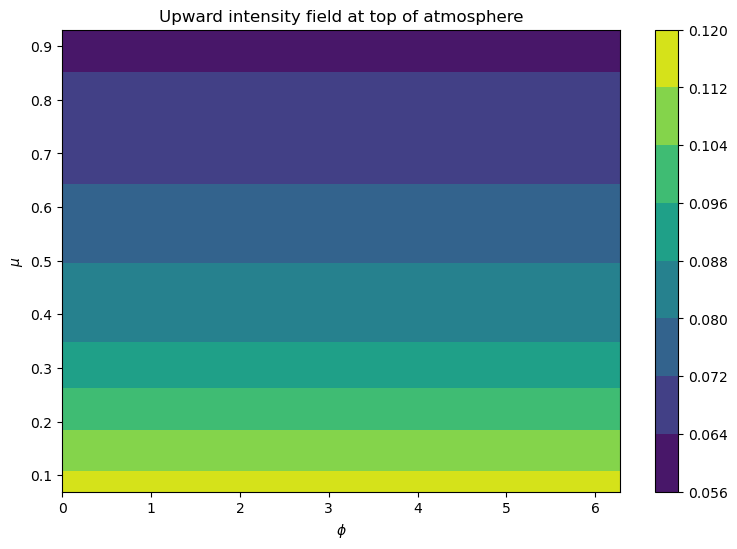

In [12]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

----------

# 9b

**PythonicDISORT**

In [13]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.empty(6)
for i in range(6):
    tau_arr[i] = np.sum(np.arange(i + 2))
omega_arr = 0.6 + np.arange(1, 7) * 0.05
NQuad = 8
Leg_coeffs_all = np.tile(
    np.array(
        [1, 2.00916, 1.56339, 0.67407, 0.22215, 0.04725, 0.00671, 0.00068, 0.00005]
    )
    / (2 * np.arange(9) + 1),
    (6, 1),
)
mu0 = 0
I0 = 0
phi0 = 0

# Optional (used)
b_neg = 1 / pi

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes=[]
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [14]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_neg=b_neg,
)

**Stamnes' DISORT**

In [15]:
# tau test points
tau_test_arr = np.array([0, 1.05, 2.1, 6, 21])
Ntau = len(tau_test_arr)

In [16]:
# Stamnes' DISORT arguments
nlyr = 6
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = b_neg
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [17]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/9b_test.npz")

**Comparisons**

In [18]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 2.576531828168971e-08
Difference ratio = 6.125620247828119e-07

Downward (diffuse) fluxes
Difference = 1.1920928977282585e-07
Difference ratio = 3.967778612553841e-07

Direct (downward) fluxes
Difference = 0.0
Difference ratio = 0.0

Intensities

At tau = 0.0
Max pointwise difference = 5.53211412651633e-08
At tau = 1.05
Max pointwise difference ratio = 9.347970250378194e-07



**Does the test pass?**

In [19]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/9b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [20]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

Text(0.5, 1.0, 'Upward intensity field at top of atmosphere')

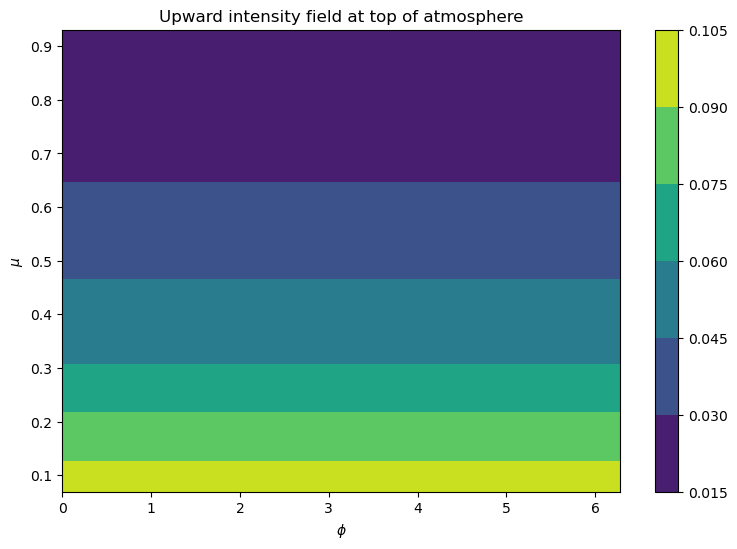

In [21]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)

-------

# 9c

**PythonicDISORT**

In [22]:
from PythonicDISORT.subroutines import blackbody_contrib_to_BCs
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [23]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.empty(6)
for i in range(6):
    tau_arr[i] = np.sum(np.arange(i + 2))
omega_arr = 0.6 + np.arange(1, 7) * 0.05
NQuad = 8
Leg_coeffs_all = np.vstack([(l / 7) ** np.arange(NQuad + 1) for l in np.arange(1, 7)])
mu0 = 0.5
I0 = pi
phi0 = 0

# Optional (used)
omega_s = 0.5
BDRF_Fourier_modes=[lambda mu, neg_mup: np.full((len(mu), len(neg_mup)), omega_s)]

TEMPER = 600 + np.arange(7) * 10
WVNMLO = 999
WVNMHI = 1000
BTEMP = 700
TTEMP = 550
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI) * (1 - omega_arr)[:, None]
b_pos = blackbody_contrib_to_BCs(BTEMP, WVNMLO, WVNMHI) * (1 - omega_s)
b_neg = blackbody_contrib_to_BCs(TTEMP, WVNMLO, WVNMHI) + 1 # Emissivity 1

# Optional (unused)
NLeg = None
NFourier = None
only_flux = False
f_arr = 0
NT_cor = False
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [24]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
)

**Stamnes' DISORT**

In [25]:
# tau test points
tau_test_arr = np.array([0, 1.05, 2.1, 6, 21])
Ntau = len(tau_test_arr)

In [26]:
# Stamnes' DISORT arguments
nlyr = 6
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 1
albedo = omega_s
btemp = BTEMP
ttemp = TTEMP
temis = 1
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [27]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/9c_test.npz")

**Comparisons**

In [28]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.00042858862903738526
Difference ratio = 8.379362479888764e-05

Downward (diffuse) fluxes
Difference = 0.00029268528910009195
Difference ratio = 6.924157017513808e-05

Direct (downward) fluxes
Difference = 4.371139006309477e-08
Difference ratio = 1.8069079352853477e-07

Intensities

At tau = 21.0
Max pointwise difference = 0.0027373888669937063
At tau = 21.0
Max pointwise difference ratio = 0.0017543201318550158



**Does the test pass?**

In [29]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/9c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [30]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

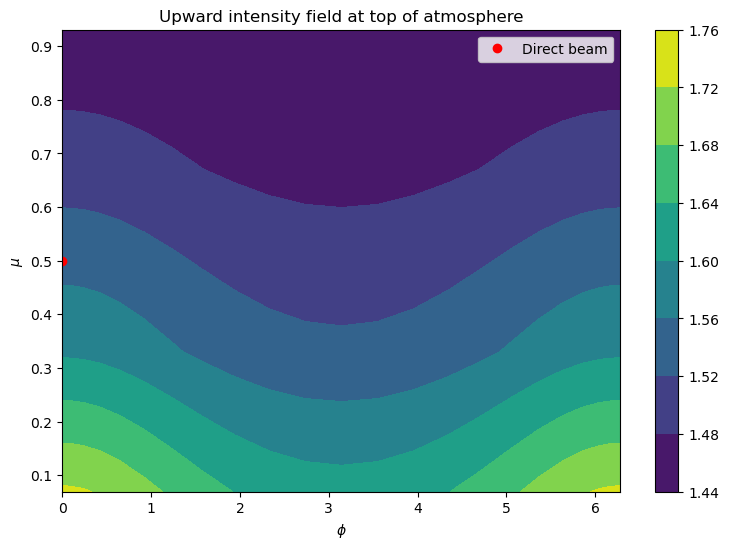

In [31]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-----------

# 9corrections

Given significant `f_arr` values, will the corrections result in better accuracy?

**PythonicDISORT**

In [32]:
from PythonicDISORT.subroutines import blackbody_contrib_to_BCs
from PythonicDISORT.subroutines import generate_s_poly_coeffs

In [33]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = np.empty(6)
for i in range(6):
    tau_arr[i] = np.sum(np.arange(i + 2))
omega_arr = 0.9 + np.arange(1, 7) * 0.01
NQuad = 4
Leg_coeffs_all = np.vstack([((l / 3 + 4) / 7) ** np.arange(NQuad * 5) for l in np.arange(1, 7)])
mu0 = 0.5
I0 = pi
phi0 = 0

# Optional (used)
omega_s = 0.5
BDRF_Fourier_modes=[lambda mu, neg_mup: np.full((len(mu), len(neg_mup)), omega_s)]

TEMPER = 600 + np.arange(7) * 10
WVNMLO = 999
WVNMHI = 1000
BTEMP = 700
TTEMP = 550
# Emissivity is (1 - omega_arr) by Kirchoff's law of thermal radiation
s_poly_coeffs=generate_s_poly_coeffs(tau_arr, TEMPER, WVNMLO, WVNMHI) * (1 - omega_arr)[:, None]
b_pos = blackbody_contrib_to_BCs(BTEMP, WVNMLO, WVNMHI) * (1 - omega_s)
b_neg = blackbody_contrib_to_BCs(TTEMP, WVNMLO, WVNMHI) + 1 # Emissivity 1

# Optional (unused)
NLeg = None
NFourier = None
only_flux = False
#f_arr = 0
#NT_cor = False
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [34]:
# Call pydisort function

mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    # No corrections
)

mu_arr, flux_up_dM, flux_down_dM, u0, u_NT = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
    b_pos=b_pos,
    b_neg=b_neg,
    s_poly_coeffs=s_poly_coeffs,
    BDRF_Fourier_modes=BDRF_Fourier_modes,
    # Corrections
    f_arr=Leg_coeffs_all[:, NQuad],
    NT_cor=True,
)
print("f_arr =", Leg_coeffs_all[:, NQuad])

f_arr = [0.14685753 0.19753086 0.2603082  0.33697893 0.42945583 0.53977509]


**Setup for tests**

In [35]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [36]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 1.05, 2.1, 6, 21])
Ntau = len(tau_test_arr)

In [37]:
# Stamnes' DISORT arguments
nlyr = 6
nmom = 5 * NQuad
nstr = 4 * NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = True
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = np.concatenate([[tau_arr[0]], np.diff(tau_arr)])
ssalb = omega_arr
pmom = Leg_coeffs_all.T
temper = TEMPER
wvnmlo = WVNMLO
wvnmhi = WVNMHI
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 1
albedo = omega_s
btemp = BTEMP
ttemp = TTEMP
temis = 1
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [38]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/9corrections_test.npz")

In [39]:
print("Without corrections")
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Without corrections
Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.01110960141904016
Difference ratio = 0.002266919426546172

Downward (diffuse) fluxes
Difference = 0.014682541629425394
Difference ratio = 0.0023702961332929496

Direct (downward) fluxes
Difference = 4.371139006309477e-08
Difference ratio = 1.8069079352853477e-07

Intensities

At tau = 0.0
Max pointwise difference = 0.06911426569533097
At tau = 0.0
Max pointwise difference ratio = 0.03919935155907838



In [40]:
print("With delta-scaling and NT corrections")
(
    diff_flux_up_dM,
    ratio_flux_up_dM,
    diff_flux_down_diffuse_dM,
    ratio_flux_down_diffuse_dM,
    diff_flux_down_direct_dM,
    ratio_flux_down_direct_dM,
    diff_NT,
    diff_ratio_NT,
) = _compare(results, mu_to_compare, reorder_mu, flux_up_dM, flux_down_dM, u_NT)

With delta-scaling and NT corrections
Max pointwise differences

Upward (diffuse) fluxes
Difference = 0.004794243247683738
Difference ratio = 0.0009782676032945436

Downward (diffuse) fluxes
Difference = 0.00870651337438666
Difference ratio = 0.0014055478613057872

Direct (downward) fluxes
Difference = 4.371139006309477e-08
Difference ratio = 1.8069079352853477e-07

Intensities

At tau = 2.1
Max pointwise difference = 0.010067514209913586
At tau = 2.1
Max pointwise difference ratio = 0.005664629397768609



**Does the test pass?**

In [41]:
# Check whether the corrections improve accuracy on average
assert np.mean(diff_flux_up - diff_flux_up_dM) > 0
assert np.mean(diff_flux_down_diffuse - diff_flux_down_diffuse_dM) > 0
assert np.mean(diff - diff_NT) > 0

'''np.savez_compressed (
    "Stamnes_results/9corrections_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


--------